# Hyper-parameter tuning for GloVe embedding and LSTM network

### Set up environnent, access to google drive, import librairies


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x

### Import librairies

In [0]:
import tensorflow as tf
import os, sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('Problem with GPU device')

In [26]:
from __future__ import print_function
sys.path.insert(0, os.path.abspath('/content/drive/My Drive/ML_Project_2/'))
import sys, os
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import gensim
from helpers import *
from models_LSTM import *
from multiprocessing import Pool
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.python.keras.layers.embeddings import Embedding
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import re

tf.compat.v1.get_default_graph

<function tensorflow.python.framework.ops.get_default_graph>

In [0]:
# Define path to Google Drive 
path_pr = "/content/drive/My Drive/ML_Project_2/"

### Define useful functions


In [0]:
def not_processing(data_train, data_test):
    """
    Apply negation processing 

    :param data_train: Training dataset
    :param data_test: Test dataset
    :return: Training and test dataset with negation processing
    """
    for idx, tweet in enumerate(data_train):
        tweet = ' '.join(tweet)
        data_train[idx] = re.sub(r"\w+n't\s?", 'not ', tweet)

    for idx, tweet in enumerate(data_test):
        tweet = ' '.join(tweet)
        data_test[idx] = re.sub(r"\w+n't\s?", 'not ', tweet)

    to_not = ['havent', 'doesnt', 'cant', 'dont', 'shouldnt', 'arent', 'couldnt', "didnt", "hadnt", "mightnt",
              "mustnt", "neednt", "wasnt", "wont", "wouldnt", 'neednt', 'isnt', 'werent']

    for word in to_not:
        data_train = [re.sub(r'\b' + word + r'\b', 'not', tweet) for tweet in data_train]
        data_test = [re.sub(r'\b' + word + r'\b', 'not', tweet) for tweet in data_test]

    return data_train, data_test


def tokenize(data_train, data_test, len_max_tweet, n_dim):
    """
    Tokenize tweets and load embedding matrix
    
    :param data_train: Training dataset
    :param data_test: Test dataset
    :param len_max_tweet: Maximum length of the tweets in the datasets
    :param n_dim: Embedding dimension
    :return: Tokenized training and test dataset, size of the dataset vocabulary and embedding matrix
    """
    # Create a tokenizer instance
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1e6)

    # Fit the tokenizer on the training set
    tokenizer.fit_on_texts(data_train)

    # Tokenize data
    data_train = tokenizer.texts_to_sequences(data_train)
    data_test = tokenizer.texts_to_sequences(data_test)

    # Compute vocabulary size
    vocab_size = len(tokenizer.word_index) + 1

    embeddings_dictionary = dict()
    glove_file = open(path_pr + 'glove/glove.twitter.27B.' + str(n_dim) + 'd.txt', encoding="utf8")

    # Extract glove matrix 
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

    embedding_matrix = np.zeros((vocab_size, n_dim))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    return data_train, data_test, vocab_size, embedding_matrix

### Load data

In [29]:
print("Loading Data ...")
# Load full dataset or not: 'f' or 'nf'
full='nf'
processed=False

if processed:
    data_train = np.load(path_pr + 'Processed_Data_1/lem_data_nf.npy', allow_pickle=True)
    data_test = np.load(path_pr + 'Processed_Data_1/lem_data_test.npy', allow_pickle=True)
    labels = np.load(path_pr + 'Processed_Data_1/labels_train_nf.npy', allow_pickle=True)
    dataset_type = 'processed'

else:
    data_train = np.load('/content/drive/My Drive/ML_Project_2/Processed_Data/raw_data_train_' + full + '.npy', allow_pickle=True)
    data_test = np.load('/content/drive/My Drive/ML_Project_2/Processed_Data/raw_data_test' + '.npy', allow_pickle=True)
    labels = np.load('/content/drive/My Drive/ML_Project_2/Processed_Data/labels_train_'+ full +'_sl5.npy')
    dataset_type = 'raw'

# If labels are -1 instead of 0
labels = np.where(labels == -1, 0, labels)



Loading Data ...


In [0]:
# To train without the full set
n_train = -1

if n_train > 0:
    data_train = data_train[:n_train]
    labels = labels[:n_train]


In [31]:
print("Computing len_max_tweet", flush=True)

# Max length of tweet (after removed not in vocab words)
len_max_tweet = np.max([len(tweet) for tweet in data_train])
len_max_tweet = np.max((len_max_tweet, np.max([len(tweet) for tweet in data_test])))

Computing len_max_tweet


In [32]:
print("Start to convert negative words", flush=True)

# Negation processing
data_train_not, data_test_not = not_processing(data_train, data_test)


Start to convert negative words


### Define callback for the hyperparameter

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback

class GetAcc(Callback):
    def __init__(self, data_test, labels_test, acc_array, kfold_idx):
        self.data_test = data_test
        self.labels_test = labels_test
        self.acc = acc_array
        self.kfold_idx = kfold_idx

    def on_epoch_end(self, epoch, logs={}):
        loss, accuracy = self.model.evaluate(self.data_test, self.labels_test, verbose=0)
        self.acc[self.kfold_idx, epoch] = accuracy
        #print('kfold_idx:', self.kfold_idx, ' Epochs #', epoch)
        #print('\nTesting loss: {}, acc: {}\n'.format(loss, accuracy))

### Hyperparameter tuning

In [35]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

results = pd.DataFrame(columns=['ed', 'nf', 'lr', 'bs', 'ep', 'accuracy', 'mean_accuracy', 'std_accuracy'])

# Number of k-folds
n_splits = 10

# Define parameters to tune 
epochs = 9
filters_arr = [400]
n_dims = [200]
lr = 1e-3;
batch_sizes = [64, 128]

for n_dim in n_dims:
  print('ndim = ', n_dim)

  data_test = data_test_not.copy()
  data_train, y_train = data_train_not.copy(), labels.copy()

  data_train, data_test, vocab_size, embedding_matrix = tokenize(data_train, data_test, len_max_tweet, n_dim)

  data_train = pad_sequences(data_train, padding='post', maxlen=len_max_tweet)
  data_test = pad_sequences(data_test, padding='post', maxlen=len_max_tweet)

  for filters in filters_arr:
      print('filter = ', filters)

      for batch_size in batch_sizes:
        print('batch_size = ', batch_size)

        acc_array = np.zeros((n_splits, epochs))
        k_i = 0

        for train_index, test_index in KFold(n_splits).split(data_train):
            x_train, x_test = data_train[train_index], data_train[test_index]
            y_train_, y_test = y_train[train_index], y_train[test_index]    
            
            model = build_model_lstm_emb(filters, vocab_size, n_dim, embedding_matrix, len_max_tweet, lr)
            
            if (k_i == 0):
              model.summary()

            print('k_fold:', k_i)

            model.fit(x_train, y_train_,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[GetAcc(x_test, y_test, acc_array, k_i)])
            k_i += 1

        for n in range(epochs):
            results = results.append({'ed': n_dim, 'nf': filters, 'lr': lr, 'bs': batch_size, 'ep': n+1,
                                        'accuracy': acc_array[:, n], 'mean_accuracy': np.mean(acc_array[:, n]), 
                                        'std_accuracy': np.std(acc_array[:, n])}, ignore_index=True)

imax = results['mean_accuracy'].idxmax()
print("Best: %f using \n %s" % (results['mean_accuracy'].iloc[imax], results.iloc[imax]))


ndim =  200
filter =  400
batch_size =  64
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 49, 200)           18761400  
_________________________________________________________________
lstm_26 (LSTM)               (None, 400)               961600    
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 401       
Total params: 19,723,401
Trainable params: 962,001
Non-trainable params: 18,761,400
_________________________________________________________________
k_fold: 0
Train on 163188 samples, validate on 18133 samples
Epoch 1/9
163188/163188 [==============================] - 32s 195us/sample - loss: 0.4463 - accuracy: 0.7860 - val_loss: 0.5175 - val_accuracy: 0.7382
Epoch 2/9
163188/163188 [==============================] - 30s 186us/sample - loss: 0.3816 - accuracy: 0.8250

KeyboardInterrupt: ignored

Best: 0.811141 using 
 ed                                                             200
nf                                                             400
lr                                                           0.001
bs                                                              64
ep                                                               5
accuracy         [0.8270004987716675, 0.7571696639060974, 0.794...
mean_accuracy                                             0.811141
std_accuracy                                             0.0261867
Name: 4, dtype: object


<function matplotlib.pyplot.show>

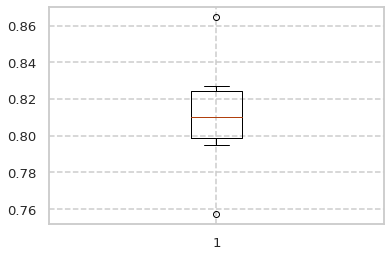

In [36]:
imax = np.argmax(results['mean_accuracy'].values)
print("Best: %f using \n %s" % (results['mean_accuracy'].iloc[imax], results.iloc[imax]))



import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

x = results['accuracy'].iloc[imax]
np.save(path_pr + 'results_LSTM_raw', x)
sns.set('talk', 'whitegrid', 'dark', font_scale=0.8, font='Ricty',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

plt.boxplot(x)
plt.show


In [0]:
y_pred = np.ndarray.flatten(model.predict_classes(data_test, batch_size=batch_size))

# Replace for submission
y_pred = np.where(y_pred == 0, -1, y_pred)

# path_csv = 'Subs/'
csv_name = 'sub_tf_e' + str(epochs) + '_f' + str(filters) + '_bs' + str(batch_size) \
           + '_hd' + str(hidden_dims) + '_ks' + str(kernel_size) + '_deep_' + type_model + 'flstm_' + str(filters_lstm)

create_csv_submission(y_pred, csv_name + '.csv')
print("Output name:", csv_name)